In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random


import torch
from torch.utils.data import Dataset
import torchvision.models.segmentation as segmentation
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [3]:
model = segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

c:\Users\William Pearson\Documents\Personal\Portfolio\RadonAngleFinder\RadonAngleFinder\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\William Pearson\Documents\Personal\Portfolio\RadonAngleFinder\RadonAngleFinder\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
input_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # same ImageNet mean
        std=[0.229, 0.224, 0.225]    # same ImageNet std
    )
])


# Define the transformation pipeline for segmentation masks (e.g., grayscale label maps)
mask_transform = transforms.Compose([
    transforms.PILToTensor(),  # Converts PIL image to tensor without scaling pixel values
    transforms.Lambda(lambda x: x.squeeze().long())  # Removes channel dimension (if present) and converts to long type (for class labels)
])

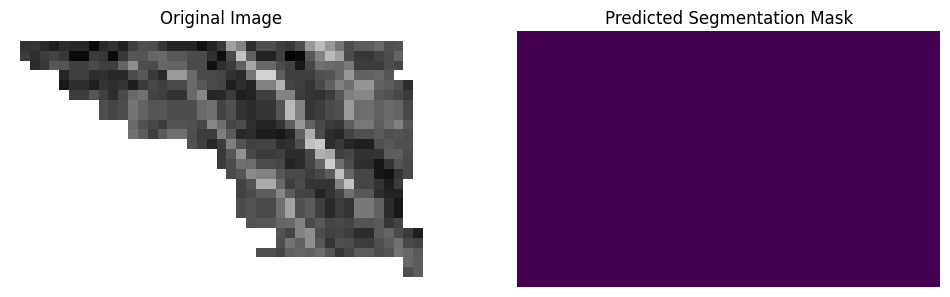

In [5]:
img_path = "src/dataset/images/Grain 1.png"
image = Image.open(img_path).convert("L")

# Run inference
input_tensor = input_transform(image).unsqueeze(0)
model.eval()
with torch.no_grad():
    output = model(input_tensor)['out'][0]

# Get predicted classes per pixel
pred_classes = output.argmax(0).byte().cpu()

# Visualize predicted segmentation mask
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Predicted segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(pred_classes*255)
plt.title("Predicted Segmentation Mask")
plt.axis('off')

plt.show()

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert("L")
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [7]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

num_classes = 2
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_dataset = SegmentationDataset("src/dataset_aug/images", "src/dataset_aug/binary_masks", input_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

In [8]:
epochs=5
model.train()
for epoch in range(epochs):
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        output = model(imgs)['out']
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Epoch 1: Loss = 0.5239
Epoch 2: Loss = 0.3988
Epoch 3: Loss = 0.3436
Epoch 4: Loss = 0.2904
Epoch 5: Loss = 0.1824


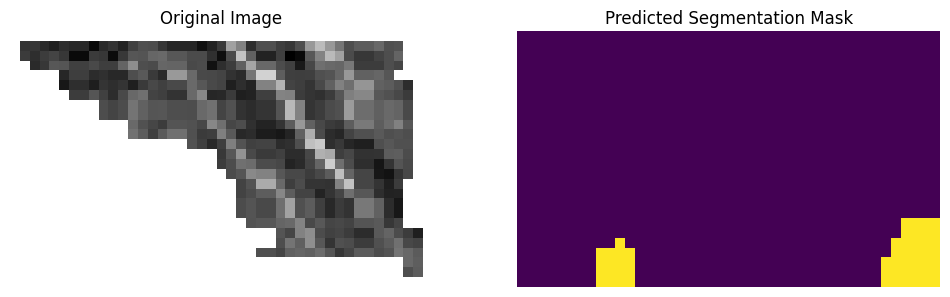

In [9]:
img_path = "src/dataset/images/Grain 1.png"
image = Image.open(img_path).convert("L")

# Run inference
input_tensor = input_transform(image).unsqueeze(0)
model.eval()
with torch.no_grad():
    output = model(input_tensor)['out'][0]

# Get predicted classes per pixel
pred_classes = output.argmax(0).byte().cpu()

# Visualize predicted segmentation mask
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Predicted segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(pred_classes*255)
plt.title("Predicted Segmentation Mask")
plt.axis('off')

plt.show()